# Particle Filter Assimilation

# Import module


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mordor_sd_assim import mordor_sd
import datetime
import litres
from save_tools import *

#  Arrays definitions

In [2]:

""" Arrays sizes definition
npmt : number of parameters
ncond: number of initial conditions ? to verify
nres : number of results colomns in the final structure
tmax : number of dates pissibly simulated by Mordor
"""
npmt  = 100   
ncond = 72
nres  = 74 #230 
tmax  = 2000


#  Function to read file parameters

In [3]:

def res2pmt(data_file) :
    """Reader of parameters file for the Mordor model
    Input:
    -------
    - data_file: file name to read
    Output:
    -------
    - pmtdict: Dictionnary with parameters
      parameters names can be retrieved with 'names' key
    variables:
    -------
    pmt     : parameters arrays filled by the litres Fortran code
    pmtdict : dictionnay with all parameters
    name    : names of each parameters
    """
    pmt = np.zeros(npmt)
    
    litres.litres(nomfic=data_file, pmtmor=pmt)
    
    name = ["mod_neige","mod_deriv","mod_lac","mod_etp","mod_glace","mod_out","sbv","pdt","dh","fglace",
           "flac","xlat","z50","ztair","lonR","nstock","cp","cetp","csbv","gtz","gpz","etp1","etp2",
           "kmin","umax","lmax","zmax","evl","kr","lkn","evn","cel","dif","qcel","qdif","kf","kfp","efp",
           "eft","lts","gm","kg","kgp","efg","jg","ptjp1","raym","qext","zs1","fs1","fgi1","fgf1","zs2",
           "fs2","fgi2","fgf2","zs3","fs3","fgi3","fgf3","zs4","fs4","fgi4","fgf4","zs5","fs5","fgi5","fgf5",
           "zs6","fs6","fgi6","fgf6","zs7","fs7","fgi7","fgf7","zs8","fs8","fgi8","fgf8","zs9","fs9","fgi9",
           "fgf9","zs10","fs10","fgi10","fgf10","nsbv","qres","lqs","x92","x93","x94","x95","x96","x97","x98","x99","x100"]
    
    pmtdict={}
    
    for i in range(npmt):
        pmtdict[name[i]] = pmt[i]
    pmtdict['names'] = name
    return pmtdict


# Mordor calculation function

In [4]:

def Calcul_MordorSD(Date, QS, NS, PS, TS, pmtdictn, cond=[np.nan]):
    """Driver for MORDOR simulation.
    Inputs:
    -------
    - Date: date objet
    - QS: observed flow rate, for comparison with the simulation
    - PS: precipitation (forcing)
    - TS: surface temperature (forcing)
    - pmtdict: model parameters, read from a parameter files of the type Param_Durance@Clapiere.res with function res2pmt
    Outputs:
    --------
    - dictionary with ("Date","Qobs","PS","T","Qam","rbase","rvers","rsurf", "S", "fneige",
      "U","L","Z","N","ep","er","Qmod","lg","agl")
      products names can be retrieved with the 'names' key
    variables:
    --------
    pmt  : parameters arrays filled by using the pmtdict dictionnary
    npdt : number of date to simulate
    JJ   : julian days computed from Date
    don  : an array with JJ,QS,PS,TS as input of the Mordor model
    res0 : output array
    init : integer (0 or 1) to initialise the Model set to 1
    cond         : array as input of the Mordor model, initial conditions ? to ask to EDF
    don_f, pmt_f, cond_f and res0_f: as respectively the arrays don, pmt, cond and res0
                   converted in arrays using Fortran-like index order
    RES          : dictionnary containing all products results
    RES['names'] : names on each product
  
    """

    pmt = np.zeros(npmt)
    for i_n in range(npmt):
        pmt[i_n] = pmtdict[pmtdict['names'][i_n]]
    
    npdt=len(Date)
    
    # julian days computation
    JJ = list()
    for id in Date: JJ.append(id.timetuple().tm_yday)
    
    don = np.zeros((tmax, 4))
    don[0:npdt,0] = np.asarray(JJ)
    don[0:npdt,1] = np.asarray(QS)
    don[0:npdt,2] = np.asarray(PS)
    don[0:npdt,3] = np.asarray(TS)

    res0 = np.zeros((tmax, nres))
    
    if cond[0]!=cond[0]: # no initialization 
        init = 0
        cond = np.zeros(ncond)+1
    else: #  initialization given
        init = 0

    cond[0] = npdt
    
    # creation of arrays using Fortran-like index order
    don_f  = np.array(don, dtype=np.float, order='F')
    pmt_f  = np.array(pmt, dtype=np.float, order='F')
    cond_f = np.array(cond, dtype=np.float, order='F')
    res0_f = np.array(res0, dtype=np.float, order='F')
    
    mordor_sd(don_f, pmt_f, cond_f, res0_f, init)
    

    # outputs data storage
    RES = {}
       # list of the names of each column in the outputs (in the same order as in the fortran)
    list_res   = ["Q", "fneige", "S", "N",
          "U_1", "U_2", "U_3", "U_4", "U_5", "U_6", "U_7", "U_8", "U_9", "U_10",
         "L_1", "L_2", "L_3", "L_4", "L_5", "L_6", "L_7", "L_8", "L_9", "L_10",
         "Z_1", "Z_2", "Z_3", "Z_4", "Z_5", "Z_6", "Z_7", "Z_8", "Z_9", "Z_10",
         "S_1", "S_2", "S_3", "S_4", "S_5", "S_6", "S_7", "S_8", "S_9", "S_10",
         "sns_1", "sns_2", "sns_3", "sns_4", "sns_5", "sns_6", "sns_7", "sns_8", "sns_9", "sns_10",
         "snl_1", "snl_2", "snl_3", "snl_4", "snl_5", "snl_6", "snl_7", "snl_8", "snl_9", "snl_10",
         "tst_1", "tst_2", "tst_3", "tst_4", "tst_5", "tst_6", "tst_7", "tst_8", "tst_9", "tst_10"]

    RES['names']  = list_res
    
    RES['Date']   = Date[0:npdt]
    RES['Qobs']   = np.asarray(QS[0:npdt])
    RES['Sobs']   = np.asarray(NS[0:npdt])
    RES['PS']     = np.asarray(PS[0:npdt])
    RES['T']      = np.asarray(TS[0:npdt])
    
    # filling the RES dictionary with each Mordor output
    for i_r in range(nres):
        RES[list_res[i_r]] = res0_f[0:npdt,i_r]


    return RES

# Function to create cond array (initial condition)

In [5]:
def make_cond_init(RES, npdt):
    """
    Function to create cond array (initial condition)
    Initial condition is made from last values (last date of simulation)
    of Mordor outputs
    -----
    Input:
    - RES: dictionary containing outputs from Mordor
    - nptd: nb of dates that will be simulated (can be 0 because
            this element is corrected juste before Mordor calling)
    Output:
    - cond: array containing Mordor initialization
    """
    
    # liste of each parameter need to be given in cond array
    list_cond_init = ["npdt", "N",\
         "U_1", "L_1", "Z_1", "S_1", "sns_1", "snl_1", "tst_1",\
         "U_2", "L_2", "Z_2", "S_2", "sns_2", "snl_2", "tst_2",\
         "U_3", "L_3", "Z_3", "S_3", "sns_3", "snl_3", "tst_3",\
         "U_4", "L_4", "Z_4", "S_4", "sns_4", "snl_4", "tst_4",\
         "U_5", "L_5", "Z_5", "S_5", "sns_5", "snl_5", "tst_5",\
         "U_6", "L_6", "Z_6", "S_6", "sns_6", "snl_6", "tst_6",\
         "U_7", "L_7", "Z_7", "S_7", "sns_7", "snl_7", "tst_7",\
         "U_8", "L_8", "Z_8", "S_8", "sns_8", "snl_8", "tst_8",\
         "U_9", "L_9", "Z_9", "S_9", "sns_9", "snl_9", "tst_9",\
         "U_10", "L_10", "Z_10", "S_10", "sns_10", "snl_10", "tst_10"]
    

    cond = np.zeros(ncond)
    # npdt corresponds to nb of dates in Mordor simulations,
    # it will be replaced just before Mordor calling
    cond[0] = npdt

    # cond filling
    for i_c in range(ncond):
        # skip first element (already stored)
        if i_c==0: continue
        # parameters are retrieved from RES dictionary (output of Mordor)
        # last value (last date of simulation) of each parameter is taken
        cond[i_c] = RES[list_cond_init[i_c]][-1]

    return cond


# Auto-regressif model

In [6]:
def AR1(nb, phi, s):

    """ Autoregressive model of order one
    Inputs:
    -------
    - nb : size of sample
    - phi: phi parameter ( exp(-dt/tau) )
    - var: scale of the white noise
    --------
    - Outputs
    --------
    - x: autoregressive model result
    """
    
    # array of same size as forcings +1
    x = np.empty(nb+1)
    
    # first element is set to 0
    x[0]=0.
    
    # array containing random values (Gaussian dstribution
    # with zero mean and standard deviation of s
    eps=np.random.normal(0, s, nb)
    
    # Autoregressive model of order one
    # Loop on each step, using previous value and random values
    # using formula :  x[i+1]=x[i]*phi+eps[i]
    for i in range(nb):
        x[i+1]=x[i]*phi+eps[i]
    
    # return result excepted first step (set to 0)
    return x[1:]

# Particle filter function

In [7]:
def particle_filter_analysis(Qo, Q, So, S, R_Q, R_S):
    """Perform particle filter analysis
    -----
    Inputs:
    -------
    - Qo : Flow rate observed
    - Q  : Flow rate simulated
    - So : Snow observed
    - S  : Snow simulated
    - R_Q : Flow rate observation error (ratio of obs value)
    - R_S : Snow observation error (ratio of obs value)
    --------
    - Outputs
    --------
    - indices: array of particles indices after resampling
    """
    
    # Retreave nb of time steps and Nb of particles
    npdt, N_p = np.shape(S)
    
    # array of weight for each oarticle
    weight = np.zeros(N_p)
    
    #replace 0 values by NaN (to not consider them in calculation)
    Q=np.where(np.asarray(Q)==0, np.nan, Q)
    S=np.where(np.asarray(S)==0, np.nan, S)
    Qo=np.where(np.asarray(Qo)==0, np.nan, Qo)
    So=np.where(np.asarray(So)==0, np.nan, So)
    # Weight calculation of each particle (based on RMSE on the size of the window)

    for ie in range(N_p):
        weight[ie] = np.exp(-0.5*np.sqrt(np.nansum( (((Q[:, ie] - Qo[:])/(Qo[:]*R_Q))**2)  + (((S[:, ie] - So[:])/(So[:]*R_S))**2)  )))
        
    weight_norm = weight[:]/np.sum(weight)
    
    indices=[0]*N_p
    
    cdf = np.zeros(N_p)
    for i in range(N_p):
        cdf[i] = np.sum(weight_norm[:i+1])
    
    ## resampling
    urand = np.random.random()/N_p
    for i in range(N_p):
        indices[i] = np.searchsorted(cdf, urand)
        urand += 1./N_p
    
    print('indices after resampling: ',indices)
    
    # return indices of particles duplicated
    return indices



# Reading the ensemble simulation file

In [8]:

def lec_fichier_ens(infile, num_bande):
    """
    Netcdf file reading function and calculation of CRPS and RMSE
    Inputs:
    -infile: file to read
    Outputs:
    -Date: list of dates (object)
    -Q_obs: Q observes (function of time)
    -Q_ens: Q simulates (function of time, for each member)
    -S_ens: S simulates (function of time, for each member)
    """
       
    print('lecture ', infile)
    data_0 = lec_tabs(infile)
    
    Q_obs      = data_0['Q_obs']
    S_obs      = data_0['S_obs']
    Q_ens      = data_0['Q_ens']
    S_ens      = data_0['S_ens']
    S_1_ens      = data_0['S_1_ens']
    S_2_ens      = data_0['S_2_ens']
    S_3_ens      = data_0['S_3_ens']
    S_4_ens      = data_0['S_4_ens']
    S_5_ens      = data_0['S_5_ens']
    S_6_ens      = data_0['S_6_ens']
    S_7_ens      = data_0['S_7_ens']
    S_8_ens      = data_0['S_8_ens']
    S_9_ens      = data_0['S_9_ens']
    S_10_ens     = data_0['S_10_ens']
    fneige_ens   = data_0['fneige_ens']
    PS_ens       = data_0['PS_ens']
    T_ens        = data_0['T_ens']
    PS           = data_0['PS']
    TS           = data_0['TS']
    YYYY       = data_0['DATE'][0, :]
    mm         = data_0['DATE'][1, :]
    dd         = data_0['DATE'][2, :]
    HH         = data_0['DATE'][3, :]
    MM         = data_0['DATE'][4, :]
    
    npdt, n_ens = np.shape(Q_ens)
    
    S_bande_ens = data_0['S_'+str(num_bande)+'_ens']
    
     # list dates
    date_l = list()
    for i_t in range(npdt):
        date_l.append(datetime.datetime(year=int(YYYY[i_t]), month=int(mm[i_t]), day=int(dd[i_t])))
    
    return date_l, PS_ens, T_ens, PS, TS, Q_obs, S_obs, Q_ens, S_bande_ens

In [19]:
"""
Initialization interface
- d_ini_known  : beginning forcing date (format: YYYY-MM-DD)
- d_end_known  : end forcing date
- d_ini_FP     : beginning particles filter

"""
# year of the end of assimilation
year = 2016

# date of beginning of simulation
d_ini_known   = str(year-3) + "-09-01"

# date of the beginning of assimilation
d_ini_FP      = str(year-1) + "-12-01"
# date of the end of assimilation
d_end_known   = str(year)   + "-03-31"

# Error for weights calculation (ratio of obs values) of particles

R_Q = 0.05
R_S = 0.2 #0.2

# size of assimilation windows (in days) 

days_step     = 10

# Parameters for AR1 model, phi of precipitation and temperature:

phi_P= 0.25
phi_T= 0.95

# Parameters for AR1 model, std of precipitation and temperature:

std_P= 0.35
std_T= 0.33 #* 0.2


# Duplicated particles will be perturbed with AR1 model
# but amplitudes can attenuated with this coefficient
facteur_perturb_duplique = 0.2

# Flag to enable/disable particle filter with:
# Flow rate observations:
FP_Q =  True#True
# Snow amount observations:
FP_S = False #True

# Size of ensemble used
N_p = 50 #50

# truth number
N_verites   = 12

# Level to use to compare to snow observation (in calculation of weights) between 1 and 10
num_bande = 8

In [20]:
#Departure ensemble file
infile      = "Ensemble_50_verites_"+str(year)+".nc"

# Output file
save_file_n = "Assimilation_FP_Q_"+str(year)

# Parameters and observations files

In [21]:
data       = "QPThisto_J_isere@bvi_coche_ponserand_valid.txt"
data2      = "SWE_NRC_NDAout.txt"
file_param = "isere_FINAL_J_SIM.res"#"FINAL_J_SIM.res"

In [22]:

#
pmtdict = res2pmt(file_param)
# output mode of Mordor (specific to the wrapper)
pmtdict["mod_out"] = 3

#####################################################################
#####################################################################

if (not FP_Q): R_Q = 10000000000000.
if (not FP_S): R_S = 10000000000000.
    
# date objets creations
d_ikn = datetime.datetime.strptime(d_ini_known, '%Y-%m-%d')
d_ekn = datetime.datetime.strptime(d_end_known, '%Y-%m-%d')


# reading of the file containing the set and the 50 truths
date_l, PS_ens, T_ens, PS, TS, Q_obs, S_obs, Q_ens, S_bande_ens = lec_fichier_ens(infile, num_bande)

# index end of known period (end of assim)
index_ekn = np.where(np.asarray(date_l) == d_ekn)[0][0]

# size of tables, nb of points (of days) and nb of members
npdt, n_ens = np.shape(Q_ens)

# list of N_random verites in the start set
# We're careful not to repeat the same, every truth must be different
list_ver_in_ens = np.random.choice(range(N_p), N_verites, replace=False)

# loop on the truths
for i_ver in range(N_verites):
    print("Run verite : "+str(i_ver))
    
    Q_obsv      = np.zeros(npdt)
    Q_ensv      = np.zeros((npdt, N_p))
    S_obsv      = np.zeros(npdt)
    S_ensv      = np.zeros((npdt, N_p))
    S_n_ensv    = np.zeros((npdt, 10, N_p)) 
    fneige_ensv = np.zeros((npdt, N_p))
    PS_ensv     = np.zeros((npdt, N_p))
    T_ensv      = np.zeros((npdt, N_p))

    cond_ensv   = np.zeros((ncond, N_p))
    
    # we attribute Q and S obs according to the i_ver truth
    Q_obsv[:]   = Q_ens[:, list_ver_in_ens[i_ver]]
    S_obsv[:]   = S_bande_ens[:, list_ver_in_ens[i_ver]]
    
   

    PS_ensv[:, :] = PS_ens[:, :]
    T_ensv[:, :]  = T_ens[:, :]
    
    # objet date of beginning of assimilation (beginning of resampling)
    
    d_fp  = datetime.datetime.strptime(d_ini_FP, '%Y-%m-%d')
    
    # Loop on assimilation windows

    flag_loop_sim = True
    nb_fenetres = 0
    
    while (flag_loop_sim):
        nb_fenetres = nb_fenetres + 1
        
        # looking for indice of window beginning
        index_fp = np.where(np.asarray(date_l) == d_fp)[0][0]
      
        #  indice of end of window
        indice_fp_fin = index_fp + int(days_step)
        if (indice_fp_fin > index_ekn):
            indice_fp_fin = index_ekn

        #  for first window before PF, no resampling is done
        if  (nb_fenetres==1):
            indice_fp_fin = index_fp
            index_fp      = 0

        print('Simulations du %s au %s '%(date_l[index_fp].isoformat(), date_l[indice_fp_fin].isoformat()))

        #  loop on particles
        for i_per in range(N_p):
            
            # Mordor calling
            RES = Calcul_MordorSD(date_l[index_fp:indice_fp_fin], Q_obsv[index_fp:indice_fp_fin], S_obsv[index_fp:indice_fp_fin], \
                                  PS_ensv[index_fp:indice_fp_fin, i_per], T_ensv[index_fp:indice_fp_fin, i_per], \
                                  pmtdict, cond=cond_ensv[:, i_per])
            
            # initial condition made from Mordor outputs (used for next window)
            cond_ensv[:, i_per] = make_cond_init(RES, npdt)
            
            # storing of outputs in arrays
            Q_ensv[index_fp:indice_fp_fin, i_per]      = RES['Q'][:]
            S_ensv[index_fp:indice_fp_fin, i_per]      = RES['S'][:]
            S_n_ensv[index_fp:indice_fp_fin, 0, i_per] = RES['S_1'][:]
            S_n_ensv[index_fp:indice_fp_fin, 1, i_per] = RES['S_2'][:]
            S_n_ensv[index_fp:indice_fp_fin, 2, i_per] = RES['S_3'][:]
            S_n_ensv[index_fp:indice_fp_fin, 3, i_per] = RES['S_4'][:]
            S_n_ensv[index_fp:indice_fp_fin, 4, i_per] = RES['S_5'][:]
            S_n_ensv[index_fp:indice_fp_fin, 5, i_per] = RES['S_6'][:]
            S_n_ensv[index_fp:indice_fp_fin, 6, i_per] = RES['S_7'][:]
            S_n_ensv[index_fp:indice_fp_fin, 7, i_per] = RES['S_8'][:]
            S_n_ensv[index_fp:indice_fp_fin, 8, i_per] = RES['S_9'][:]
            S_n_ensv[index_fp:indice_fp_fin, 9, i_per] = RES['S_10'][:]
            fneige_ensv[index_fp:indice_fp_fin, i_per] = RES['fneige'][:]
            
            # end loop particles
        
        # weights calculations on each particles
        indices = particle_filter_analysis(Q_obsv[index_fp:indice_fp_fin], Q_ensv[index_fp:indice_fp_fin, :],\
                         S_obsv[index_fp:indice_fp_fin], S_n_ensv[index_fp:indice_fp_fin, num_bande-1, :], R_Q, R_S)
        
        # add days_step to d_fp (for next window)
        if (nb_fenetres>1): #  excepted for first window
            d_fp = d_fp + datetime.timedelta(days = days_step)

        # resampling
        if (nb_fenetres>1):
            # resampling of forcings and initial conditions
            cond_ensv[:, :]              = cond_ensv[:, indices]
            PS_ensv[index_fp:, :]        = PS_ensv[index_fp:, indices]
            T_ensv[index_fp:, :]         = T_ensv[index_fp:, indices]
            Q_ensv[index_fp:indice_fp_fin, :]         = Q_ensv[index_fp:indice_fp_fin, indices]
            S_ensv[index_fp:indice_fp_fin, :]         = S_ensv[index_fp:indice_fp_fin, indices]
            # fneige_ensv[index_fp:indice_fp_fin, :]    = fneige_ensv[index_fp:indice_fp_fin, indices]
            # S_n_ensv[index_fp:indice_fp_fin, :, :]    = S_n_ensv[index_fp:indice_fp_fin, :, indices]
            
            # list to spot not duplicated particles
            list_old_particle = list()
            for i_per in range(N_p):
                # test if the particle is in the list
                if indices[i_per] not in list_old_particle:
                    # only if not, then this particle will not be perturbed
                    list_old_particle.append(indices[i_per])
                    continue
                # if the particle is duplicated then it must be perturbed
                X_P = AR1( len(date_l)-index_fp, phi_P, std_P * facteur_perturb_duplique) + 1
                X_T = AR1( len(date_l)-index_fp, phi_T, std_T * facteur_perturb_duplique)
                PS_ensv[index_fp:, i_per] = PS_ensv[index_fp:, i_per] * X_P[ :]
                T_ensv[index_fp:, i_per]  = T_ensv[index_fp:, i_per]  + X_T[ :]
                #
            #
        # test if last date of simulation exceeds the end, if yes loop on windows is stopped
        if (date_l[indice_fp_fin] >= d_ekn): flag_loop_sim = False
        #
    # fend of each turth 
    
    # registration of results in netcdf file
    
    save_file_ver = save_file_n + "_" + str(i_ver) + ".nc"
    print('Saving outputs...' + str(save_file_ver))
    
    #######
    # RMSE calculation
    RMSE_PS     = np.zeros((npdt, N_p))
    RMSE_TS     = np.zeros((npdt, N_p))
    RMSE_Q      = np.zeros((npdt, N_p))
    RMSE_S      = np.zeros((npdt, N_p))
    
    for ie in range(N_p):
        RMSE_PS[:, ie] = (PS_ensv[:, ie] - PS)**2
        RMSE_TS[:, ie] = (T_ensv[:, ie] - TS)**2
        RMSE_Q[:, ie]  = (Q_ensv[:, ie] - Q_ens[:, list_ver_in_ens[i_ver]])**2
        RMSE_S[:, ie]  = (S_n_ensv[:, num_bande-1, ie] - S_bande_ens[:, list_ver_in_ens[i_ver]])**2
    
    RMSE_PS_ens = np.sqrt(np.sum(RMSE_PS[:, :], axis=1))
    RMSE_TS_ens = np.sqrt(np.sum(RMSE_TS[:, :], axis=1))
    RMSE_Q_ens  = np.sqrt(np.sum(RMSE_Q[:, :], axis=1))
    RMSE_S_ens  = np.sqrt(np.sum(RMSE_S[:, :], axis=1))

    # preparation of the tables to be recorded

    DATE       = np.zeros((5, npdt)) #YYYY, mm, dd, HH, MM

    for i_t in range(npdt):
        DATE[0, i_t] = date_l[i_t].year
        DATE[1, i_t] = date_l[i_t].month
        DATE[2, i_t] = date_l[i_t].day
        DATE[3, i_t] = date_l[i_t].hour
        DATE[4, i_t] = date_l[i_t].minute
    
    # all is registered in a dictionary
    data_out = {}
    
    data_out['cond']       = cond_ensv[:, :]
    data_out['Q_obs']      = Q_ens[:, list_ver_in_ens[i_ver]]       #Q_obsv[:]
    data_out['S_obs']      = S_bande_ens[:, list_ver_in_ens[i_ver]] #S_obsv[:]
    
    data_out['Q_vrai']      = Q_obs[:]
    data_out['S_vrai']      = S_obs[:]
    
    data_out['Q_ens']      = Q_ensv[:, :]
    data_out['S_ens']      = S_ensv[:, :]
    data_out['S_1_ens']    = S_n_ensv[:, 0, :]
    data_out['S_2_ens']    = S_n_ensv[:, 1, :]
    data_out['S_3_ens']    = S_n_ensv[:, 2, :]
    data_out['S_4_ens']    = S_n_ensv[:, 3, :]
    data_out['S_5_ens']    = S_n_ensv[:, 4, :]
    data_out['S_6_ens']    = S_n_ensv[:, 5, :]
    data_out['S_7_ens']    = S_n_ensv[:, 6, :]
    data_out['S_8_ens']    = S_n_ensv[:, 7, :]
    data_out['S_9_ens']    = S_n_ensv[:, 8, :]
    data_out['S_10_ens']   = S_n_ensv[:, 9, :]
    data_out['fneige_ens'] = fneige_ensv[:, :]
    data_out['PS_ens']     = PS_ensv[:, :]
    data_out['T_ens']      = T_ensv[:, :]
    data_out['PS']         = PS
    data_out['TS']         = TS
    data_out['DATE']       = DATE[:, :]
    data_out['RMSE_PS_ens'] = RMSE_PS_ens
    data_out['RMSE_TS_ens'] = RMSE_TS_ens
    data_out['RMSE_Q_ens']  = RMSE_Q_ens
    data_out['RMSE_S_ens']  = RMSE_S_ens

    # stored the dictionary in NetCdf file
    rec_tabs(data_out, save_file_ver)

('lecture ', 'Ensemble_50_verites_2016.nc')
Run verite : 0
Simulations du 2013-09-01T00:00:00 au 2015-12-01T00:00:00 
('indices after resampling: ', [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48])
Simulations du 2015-12-01T00:00:00 au 2015-12-11T00:00:00 
('indices after resampling: ', [0, 0, 0, 0, 1, 1, 3, 3, 5, 7, 7, 10, 10, 10, 11, 13, 13, 13, 13, 14, 15, 15, 15, 16, 17, 19, 19, 19, 19, 22, 26, 26, 27, 34, 37, 38, 39, 40, 40, 44, 44, 46, 46, 46, 48, 48, 48, 48, 49, 49])
Simulations du 2015-12-11T00:00:00 au 2015-12-21T00:00:00 
('indices after resampling: ', [0, 1, 2, 2, 3, 5, 7, 10, 11, 12, 12, 13, 15, 15, 16, 16, 17, 17, 18, 18, 20, 22, 25, 25, 26, 27, 28, 30, 30, 31, 33, 34, 35, 36, 39, 40, 40, 41, 42, 43, 43, 44, 44, 45, 45, 46, 47, 47, 48, 49])
Simulations du 2015-12-21T00:00:00 au 2015-12-31T00:00:00 
('indices after resampli

('indices after resampling: ', [43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43])
Simulations du 2015-12-01T00:00:00 au 2015-12-11T00:00:00 
('indices after resampling: ', [6, 8, 8, 17, 22, 22, 22, 24, 28, 28, 28, 28, 28, 28, 28, 28, 30, 30, 30, 30, 32, 33, 33, 33, 33, 33, 36, 36, 36, 36, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 45, 45])
Simulations du 2015-12-11T00:00:00 au 2015-12-21T00:00:00 
('indices after resampling: ', [4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18, 21, 22, 23, 24, 25, 26, 27, 29, 30, 30, 31, 31, 32, 33, 34, 34, 35, 35, 36, 37, 37, 38, 38, 39, 40, 40, 41, 41, 42, 43, 43, 44, 45, 45, 46, 46, 47, 48])
Simulations du 2015-12-21T00:00:00 au 2015-12-31T00:00:00 
('indices after resampling: ', [0, 0, 1, 1, 1, 2, 2, 3, 8, 10, 13, 17, 17, 18, 19, 19, 19, 19, 20, 20, 21, 22, 23, 24, 25, 26, 27, 2

('indices after resampling: ', [1, 4, 6, 6, 6, 6, 6, 9, 9, 9, 9, 9, 11, 11, 15, 17, 17, 17, 17, 19, 20, 20, 20, 22, 22, 23, 23, 24, 24, 24, 24, 24, 24, 24, 27, 27, 27, 32, 32, 33, 35, 35, 35, 36, 38, 39, 43, 45, 45, 45])
Simulations du 2015-12-11T00:00:00 au 2015-12-21T00:00:00 
('indices after resampling: ', [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 10, 10, 11, 11, 12, 13, 15, 16, 17, 18, 18, 22, 24, 27, 27, 28, 29, 29, 30, 31, 32, 32, 33, 33, 34, 35, 35, 36, 37, 40, 41, 43, 47])
Simulations du 2015-12-21T00:00:00 au 2015-12-31T00:00:00 
('indices after resampling: ', [1, 7, 13, 17, 20, 25, 28, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 34, 35, 35, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 40, 40, 40, 40, 45, 45, 45, 45, 48])
Simulations du 2015-12-31T00:00:00 au 2016-01-10T00:00:00 
('indices after resampling: ', [7, 7, 7, 7, 8, 8, 9, 9, 10, 10, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 16, 17, 17, 18, 18, 18, 19, 20, 20, 23, 23, 25,

('indices after resampling: ', [0, 0, 1, 2, 3, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 16, 17, 17, 17, 18, 18, 18, 20, 22, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 39, 40, 41, 41, 42, 43, 44, 44, 46, 47])
Simulations du 2016-02-09T00:00:00 au 2016-02-19T00:00:00 
('indices after resampling: ', [2, 3, 4, 5, 6, 7, 8, 8, 9, 11, 11, 13, 14, 15, 16, 17, 18, 18, 19, 20, 20, 21, 22, 23, 23, 25, 26, 28, 29, 29, 30, 30, 31, 33, 33, 34, 35, 36, 37, 38, 39, 40, 41, 41, 43, 43, 44, 45, 47, 49])
Simulations du 2016-02-19T00:00:00 au 2016-02-29T00:00:00 
('indices after resampling: ', [1, 2, 2, 3, 3, 4, 7, 8, 10, 12, 14, 14, 15, 15, 16, 17, 20, 21, 25, 26, 27, 27, 28, 29, 30, 32, 33, 33, 35, 35, 35, 36, 37, 37, 37, 38, 38, 39, 39, 42, 44, 45, 45, 46, 47, 47, 47, 49, 49, 49])
Simulations du 2016-02-29T00:00:00 au 2016-03-10T00:00:00 
('indices after resampling: ', [0, 0, 1, 2, 3, 3, 5, 6, 7, 9, 10, 14, 16, 20, 20, 21, 22, 24, 25, 26, 26, 27, 28, 29, 30, 32, 33, 34, 35, 35, 36, 36, 38

Simulations du 2016-02-09T00:00:00 au 2016-02-19T00:00:00 
('indices after resampling: ', [0, 2, 3, 4, 5, 5, 5, 6, 6, 8, 9, 10, 11, 12, 12, 13, 15, 16, 17, 17, 18, 18, 19, 20, 21, 21, 23, 24, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 48, 49, 49])
Simulations du 2016-02-19T00:00:00 au 2016-02-29T00:00:00 
('indices after resampling: ', [4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 8, 8, 11, 12, 13, 15, 18, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 27, 29, 30, 34, 35, 36, 39, 41, 47, 48, 49, 49])
Simulations du 2016-02-29T00:00:00 au 2016-03-10T00:00:00 
('indices after resampling: ', [0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 19, 20, 21, 21, 22, 23, 23, 24, 24, 25, 26, 26, 27, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 40, 42, 43, 47, 48, 49])
Simulations du 2016-03-10T00:00:00 au 2016-03-20T00:00:00 
('indices after resampling: ', [0, 1, 2, 3, 4, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 19, 20,

('indices after resampling: ', [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18])
Simulations du 2015-12-01T00:00:00 au 2015-12-11T00:00:00 
('indices after resampling: ', [0, 0, 1, 1, 1, 3, 4, 4, 4, 4, 7, 7, 7, 9, 10, 10, 10, 11, 11, 13, 13, 14, 14, 14, 14, 15, 15, 15, 17, 18, 18, 18, 19, 19, 21, 23, 26, 27, 28, 35, 37, 38, 38, 39, 40, 44, 46, 46, 48, 48])
Simulations du 2015-12-11T00:00:00 au 2015-12-21T00:00:00 
('indices after resampling: ', [1, 2, 2, 3, 3, 4, 4, 6, 7, 8, 9, 9, 10, 11, 11, 12, 12, 13, 14, 16, 17, 17, 18, 18, 19, 21, 21, 22, 22, 22, 23, 23, 24, 24, 28, 29, 29, 30, 30, 31, 31, 32, 33, 36, 37, 39, 41, 42, 46, 49])
Simulations du 2015-12-21T00:00:00 au 2015-12-31T00:00:00 
('indices after resampling: ', [1, 6, 9, 11, 15, 18, 19, 24, 28, 34, 35, 35, 35, 36, 36, 36, 36, 37, 37, 37, 38, 38, 38, 39, 39, 39, 39, 39, 40, 40, 4

# Plot

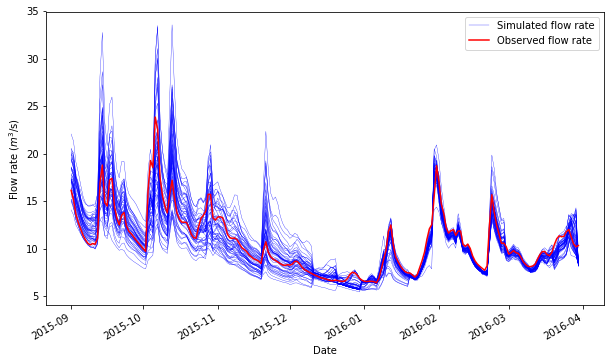

In [23]:

d_ini_plot = str(year-1) + "-09-01"
d_end_plot= str(year) + "-03-31"



d_plt = datetime.datetime.strptime(d_ini_plot, '%Y-%m-%d')
end_plt = datetime.datetime.strptime(d_end_plot, '%Y-%m-%d')

ind_deb_plot = np.where(np.asarray(date_l)==d_plt)[0][0]
ind_end_plot = np.where(np.asarray(date_l)==end_plt)[0][0]

for i_e in range(N_p):
    fig = plt.figure(1, figsize=(10, 6))

    if i_e==0:
        plt.plot(date_l[ind_deb_plot:ind_end_plot], Q_ensv[ind_deb_plot:ind_end_plot, i_e], '-b', label='Simulated flow rate', linewidth=0.3)
    else:
        plt.plot(date_l[ind_deb_plot:ind_end_plot], Q_ensv[ind_deb_plot:ind_end_plot:, i_e], '-b', linewidth=0.3)
plt.plot(date_l[ind_deb_plot:ind_end_plot], Q_ens[ind_deb_plot:ind_end_plot, list_ver_in_ens[i_ver]],'r',  label="Observed flow rate")

plt.xlabel("Date")
plt.ylabel('Flow rate ($m^3$/s)')
#plt.ylabel('S (mm)')

plt.gcf().autofmt_xdate()
plt.legend()
plt.show()